In [2]:
!pip install deepface

In [4]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from deepface import DeepFace
from deepface.modules import verification
from deepface.models.FacialRecognition import FacialRecognition

25-07-29 10:10:05 - Directory /root/.deepface has been created
25-07-29 10:10:05 - Directory /root/.deepface/weights has been created


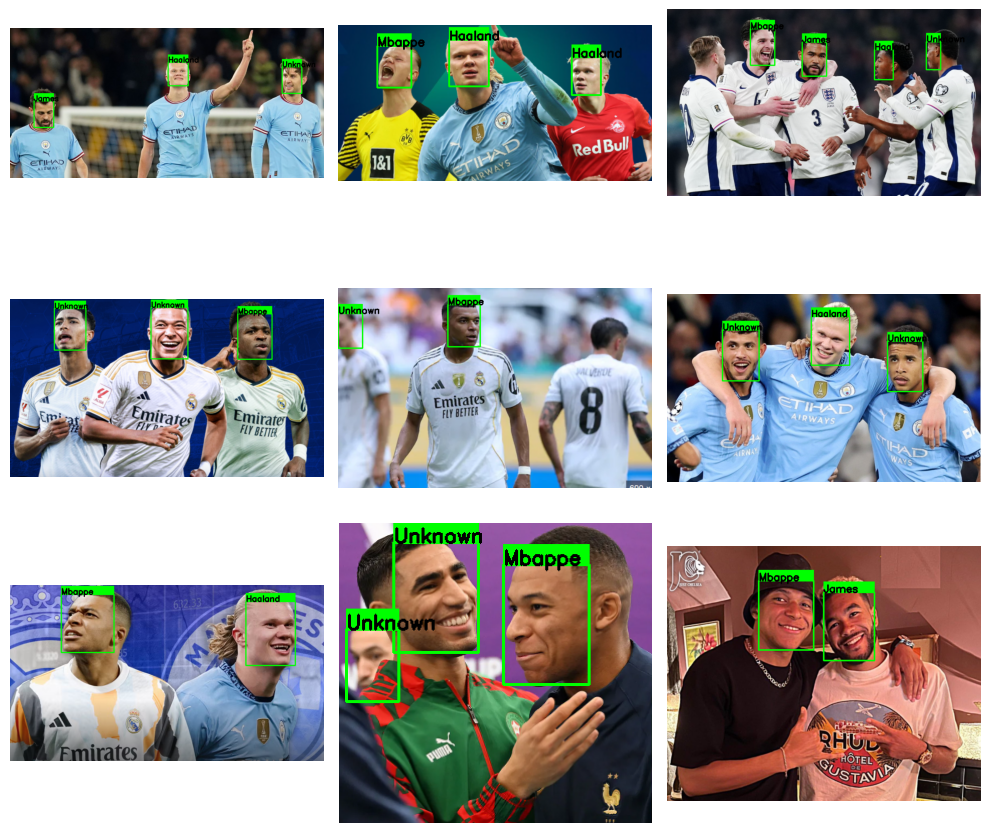

In [8]:
known_path = '/content/drive/MyDrive/Dataset/known'
test_path = '/content/drive/MyDrive/Dataset/test'

target_size = (112, 112)   # Required by ArcFace
knowing_encodings = []
knowing_names = []

model: FacialRecognition = DeepFace.build_model(model_name='ArcFace')
# threshold = verification.find_threshold('Facenet', 'euclidean')
threshold = 4.12

for person in os.listdir(known_path):
  person_folder = os.path.join(known_path, person)

  for person_img in os.listdir(person_folder):
    img_path = os.path.join(person_folder, person_img)
    face = DeepFace.extract_faces(img_path, detector_backend='retinaface', enforce_detection=True)[0]['face']

    face_img = cv2.resize(face, target_size)
    face_img = np.expand_dims(face_img, axis = 0).astype('float32')   # / 255
    img_encodeing = model.forward(face_img)
    knowing_encodings.append(img_encodeing)
    knowing_names.append(person)

n_test_images = len(os.listdir(test_path))
n_rows = math.ceil(n_test_images / 3)
plt.figure(figsize=(10, 3* n_rows))
i = 0

for image in os.listdir(test_path):
  i += 1
  image_path = os.path.join(test_path, image)
  img = cv2.imread(image_path)
  faces = DeepFace.extract_faces(image_path, detector_backend='retinaface', enforce_detection=True)

  for face in faces:
    distances = []
    face_img = face['face']
    face_img = cv2.resize(face_img, target_size)
    face_img = np.expand_dims(face_img, axis = 0).astype('float32')   # / 255
    test_encoding = model.forward(face_img)

    for encoding in knowing_encodings:
      distance = np.linalg.norm(np.array(encoding) - np.array(test_encoding))
      distances.append(distance)

    min_distance_index = np.argmin(distances)
    min_distance= distances[np.argmin(distances)]

    if min_distance < threshold :
      face_name = knowing_names[min_distance_index]
    else:
      face_name = "Unknown"

    x, y, w, h = [face['facial_area'][i] for i in ['x', 'y', 'w', 'h']]
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    cv2.rectangle(img, (x, y - 20), (x+w, y), (0, 255, 0), -1)
    cv2.putText(img, face_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 0), 2)

  plt.subplot(n_rows, 3, i)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  plt.axis('off')

plt.tight_layout()
plt.show()